Cross-Framework Introspection - User Guide
---

Cross-Framework Introspection is a tool for neural networks that can translate models between different frameworks (i.e., TensorFlow and PyTorch) and execute attribution and feature visualisation methods on them (see [todo]() for a list of available methods.
This allows you to use introspection methods implemented for PyTorch with TensorFlow models and vice versa.

This notebook explains how to use Cross-Framework Introspection.

## Installation

In [ ]:
# todo

## Calling a Captum method with a TensorFlow model

In the following, we will run [Captum's implementation of Integrated Gradients](https://captum.ai/api/integrated_gradients.html) on a TensorFlow model trained on an MNIST dataset.


In [1]:
from methods.CaptumLayerIntegratedGradients import CaptumLayerIntegratedGradients
from Main import perform_attribution, finish_execution_with_layer
from methods import method_keys
from toolsets import toolset_keys
from methods.CaptumIntegratedGradients import CaptumIntegratedGradients
import tensorflow as tf
import os
import numpy as np

In [2]:
# load (or build and train) your TensorFlow model
tf_model = tf.keras.models.load_model(os.path.join('..', 'models', 'tf_basic_cnn_mnist'))

# load your TensorFlow data
# it is also possible to use a PyTorch dataset directly, but if you already have a TensorFlow dataset
# at hand (e.g., because you used it for training), it will get translated alongside the model automatically
(mnist_x, mnist_y), _ = tf.keras.datasets.mnist.load_data()
mnist_x = mnist_x[..., np.newaxis] / 255.0
batch_size = 8

In [3]:
# depending on the introspection method we use, there are some required or optional arguments
# the arguments are split up into two dictionaries with initialization and execution arguments
# a list of all required argument keys for a certain method can be retrieved like this:
print(f'init args: {CaptumIntegratedGradients.get_required_init_keys()}')
print(f'exec args: {CaptumIntegratedGradients.get_required_exec_keys()}')
# for a description of these arguments and of the optional arguments, see the method's documentation
# (for Captum: https://captum.ai/api/, for tf-keras-vis: https://keisen.github.io/tf-keras-vis-docs/api/tf_keras_vis.html)
init_args = {}
exec_args = {'inputs': mnist_x[:batch_size], 'target': mnist_y[:batch_size]}

init args: []
exec args: ['inputs']


INFO:tensorflow:Assets written to: models\temp_tf\assets


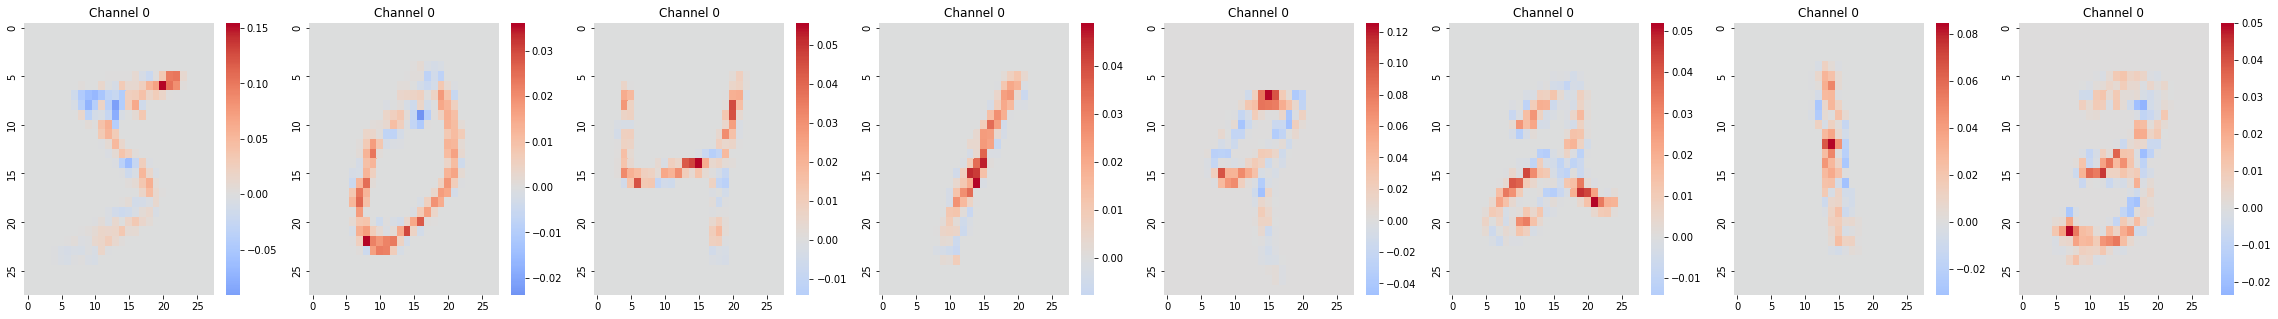

In [9]:
# the method is selected via a method_key, in this case 'integrated_gradients', which can be selected
# from a list of constants
# the toolset argument is not required here. Since the only available Integrated Gradients implementation
# is the one from Captum, Captum would be selected without the explicit argument as well

integrated_grads = perform_attribution(tf_model, method_keys.INTEGRATED_GRADIENTS, toolset_keys.CAPTUM,
                                       init_args=init_args, exec_args=exec_args, plot=True)


## Calling a Captum Layer / Neuron method

This is a special case because on of the required arguments for Captum layer / neuron methods is a layer from the PyTorch model. If you are using the method with a TensorFlow model, you usually don't have this layer.
The solution is to not provide the `layer` first and adding it later:

In [4]:
# This method has a required layer argument. If it is missing, the tool will return a list of possible
# layer keys and instructions for how to continue
print(CaptumLayerIntegratedGradients.get_required_init_keys())
intermed_result = perform_attribution(tf_model, method_keys.LAYER_INTEGRATED_GRADIENTS, toolset_keys.CAPTUM,
                                       init_args={}, exec_args=exec_args, plot=True)
print(intermed_result)

['layer']
INFO:tensorflow:Assets written to: models\temp_tf\assets


{'method': <class 'methods.CaptumLayerIntegratedGradients.CaptumLayerIntegratedGradients'>, 'translated_model': GraphModule(
  (initializers): Module()
  (Reshape_0): OnnxReshape()
  (Conv_0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (Relu_0): ReLU()
  (MaxPool_0): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=[0, 0], dilation=1, ceil_mode=False)
  (Conv_1): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (Relu_1): ReLU()
  (MaxPool_1): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=[0, 0], dilation=1, ceil_mode=False)
  (Transpose_0): OnnxTranspose()
  (Reshape_1): OnnxReshape()
  (MatMul_0): OnnxMatMul()
  (Add_0): OnnxBinaryMathOperation()
  (Relu_2): ReLU()
  (MatMul_1): OnnxMatMul()
  (Add_1): OnnxBinaryMathOperation()
  (Softmax_0): OnnxSoftmaxV1V11()
), 'translated_init_args': {}, 'translated_exec_args': {'inputs': tensor([[[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],

         [[0.],
          

KeyboardInterrupt: 

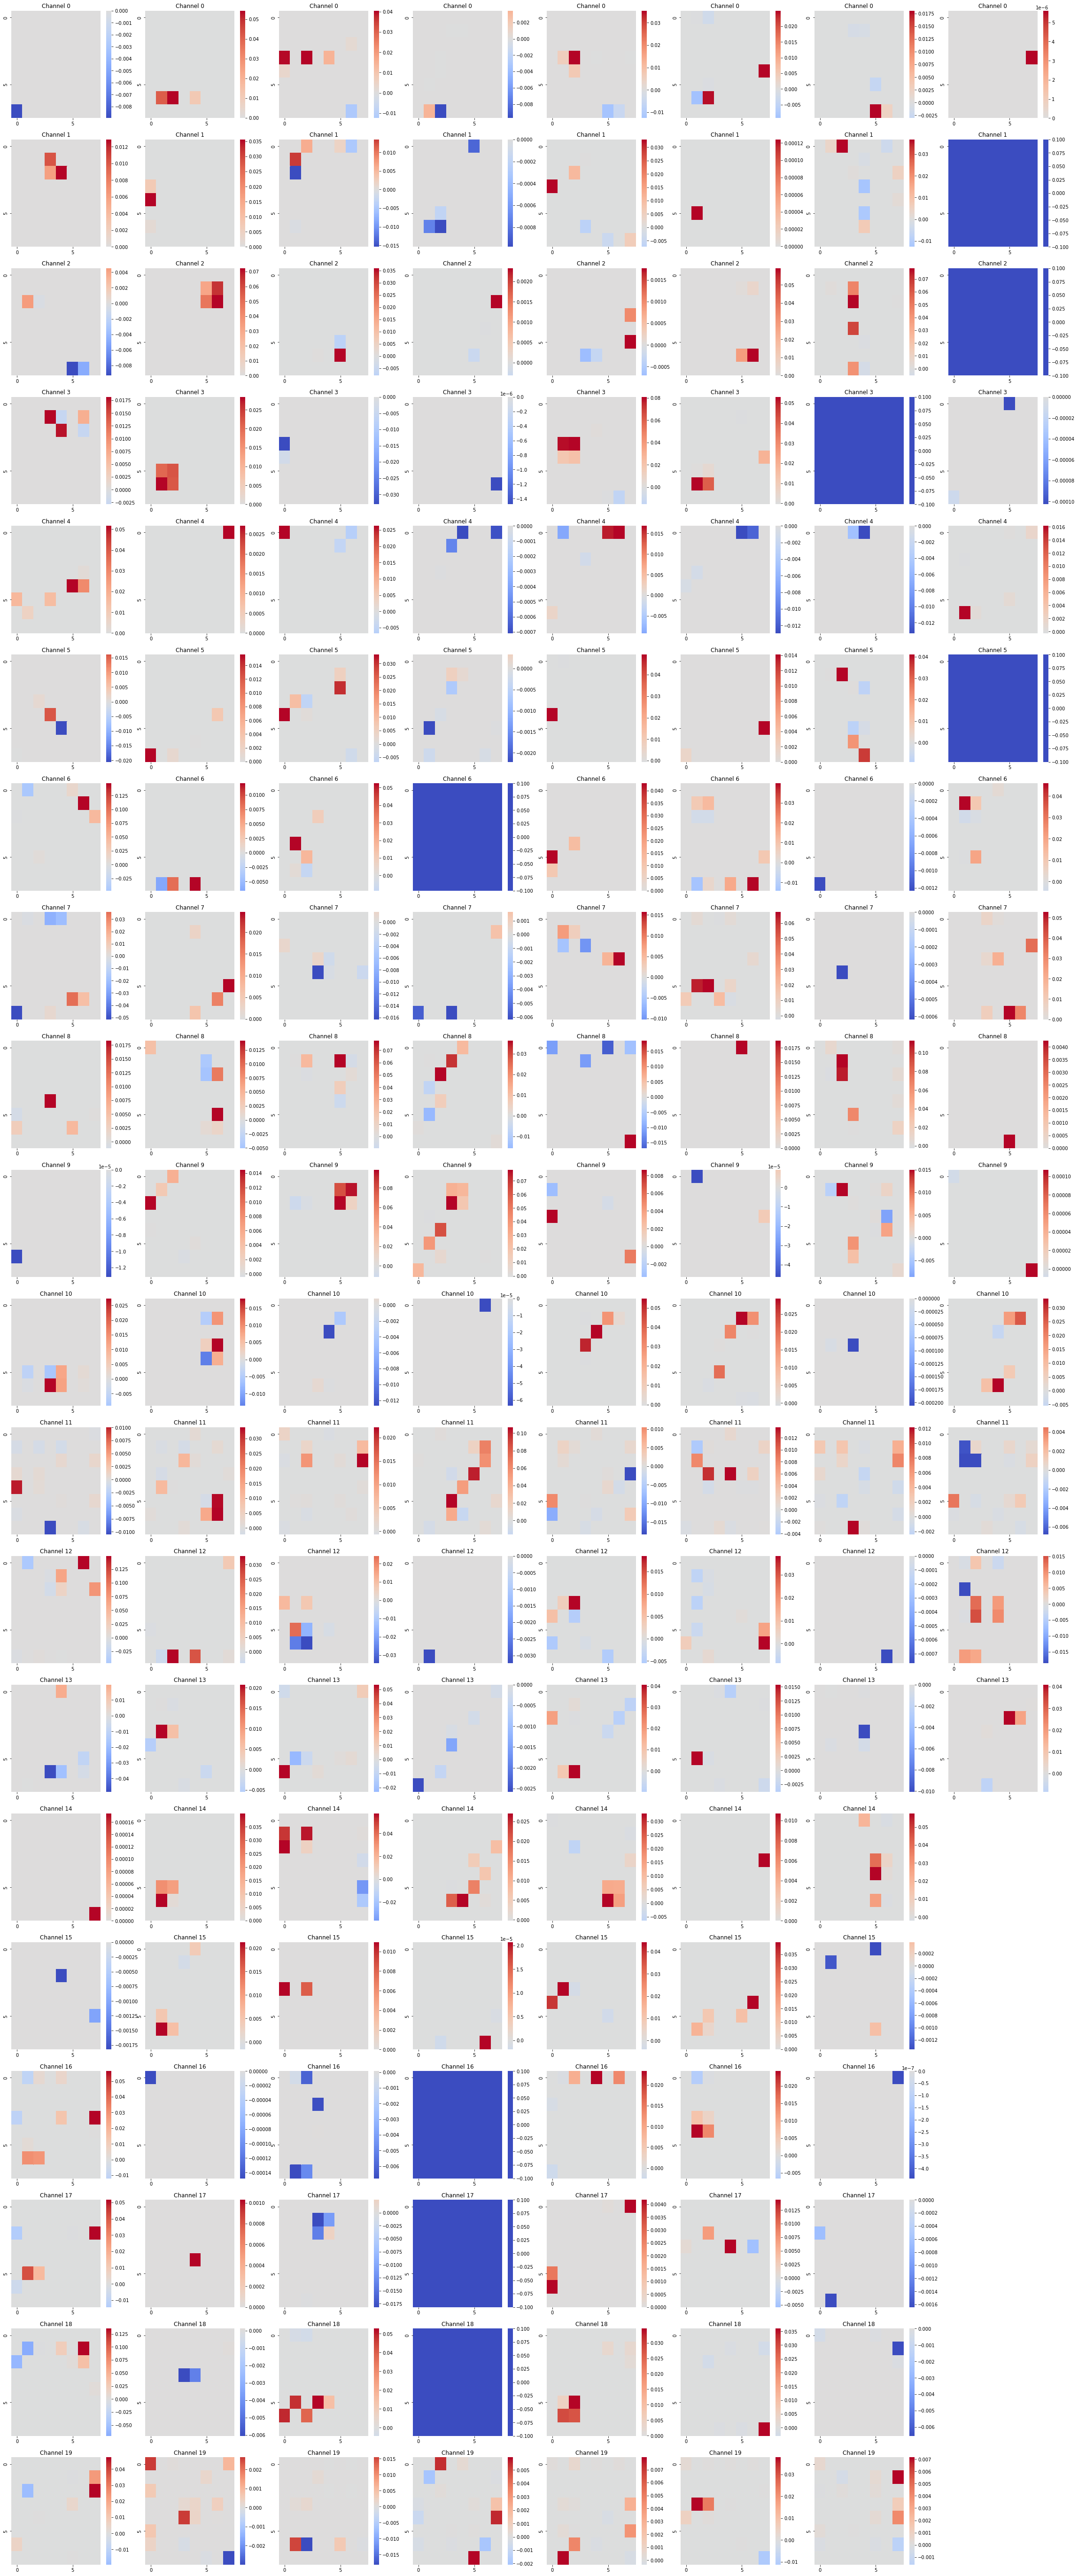

In [5]:
# here, you can specify your layer
# the tool will resolve the layer key to a layer in the translated model and continue
layer_integrated_grads = finish_execution_with_layer(intermed_result, 'Conv_1')

## Adding new introspection methods

You can easily add new introspection methods or even whole toolsets, frameworks and translations between frameworks. Here is a list of things to pay attention to:
- Inherit from the correct abstract class. There are abstract classes for toolsets, frameworks, translations and methods you should use so that your implementation can be integrated into the tool.
- Register your class. Toolsets, frameworks and translations need to be mentioned in the constant lists at the top of the Main class to be recognized by the tool. Methods need to be registered in the `get_methods()` method of their toolset class.
- Use key constants. For toolsets, frameworks and methods, there are dedicated key files which contain a list of constants for identifying the toolsets / frameworks / methods. This is not strictly necessary, but a more convenient way for users to find the method key they need.